In [1]:
import cv2
cv2.__version__

'4.5.4'

In [2]:
from PIL import Image

import napari
import scipy
import csv
import imghdr
import colorsys
import os

import numpy as np

import cv2 as cv
import matplotlib.pyplot as plt

import pyvista as pv

from csbdeep.utils import normalize
from scipy import ndimage as ndi

from skimage import filters
from skimage.draw import disk
# from skimage.segmentation import watershed
# from skimage.feature import peak_local_max
from vispy.color import Colormap
from IPython.display import display_html

from stardist.models import StarDist2D, Config3D, StarDist3D
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label

import sklearn
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM

from skimage.morphology import remove_small_holes, remove_small_objects

from napari.settings import get_settings
settings = get_settings()

from aicsimageio import AICSImage
from tifffile import imwrite

2025-01-13 11:14:06.928110: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-13 11:14:06.928770: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-13 11:14:06.932274: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-13 11:14:06.972181: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-13 11:14:07.775143: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF

In [3]:
def ellipse_pixels(center, semi_axes, rotation, image_shape):
    y, x = np.meshgrid(np.arange(imarray.shape[1]), np.arange(imarray.shape[0]), indexing='xy')
    cos_theta = np.cos(rotation)
    sin_theta = np.sin(rotation)
    
    x_rot = cos_theta * (x - center[0]) + sin_theta * (y - center[1])
    y_rot = -sin_theta * (x - center[0]) + cos_theta * (y - center[1])

    mask = (x_rot / semi_axes[0])**2 + (y_rot / semi_axes[1])**2 <= 1

    settings.application.ipy_interactive = True

    return np.column_stack(np.where(mask))

def rgb_to_hsv(rgb_array):
    hsv_list = []
    for rgb in rgb_array:
        r, g, b = rgb  # Extract the components
        h, s, v = colorsys.rgb_to_hsv(r, g, b)  # Convert to HSV
        hsv_list.append([h * 360, s * 100, v * 100])  # Scale H to degrees, S and V to percentages
    return np.array(hsv_list)

def csv_to_matrix(file_path):
    matrix = []
    with open(file_path, 'r') as file:
        reader = csv.reader(file)
        for row in reader:
            matrix.append([int(value) if value.replace('.', '', 1).isdigit() else value for value in row])
    return matrix

## File upload
Write the name of the file that needs to be investigated.

In [4]:
tiff_file='cow1_d0_1_1.tif'
tiff_stem=os.path.splitext(os.path.basename(tiff_file))[0]

img=Image.open(tiff_file)
imarray=np.array(img)
print(imarray.shape)

(3056, 2920, 3)


In [5]:
r_X=1.0
r_Y=1.0

## ROI 
This section will find the region of interest by checking the blue part. Variables: [step] will dictate the size of the square of investigation (smaller values will get a better resolution but slower run), [delta] will dictate the sensitivity of the blue level (smaller values lead to more false positive but higher values lead to more false negative).  

In [6]:
ROI_image=imarray.copy()
mask_image=np.zeros(np.shape(imarray[:,:,1]))
step=5
delta=3
holes_threshold=1000
island_threshold=2000

for i in range(1+step,imarray.shape[0],step):
    for j in range(1+step,imarray.shape[1],step):
        #print(j)
        if(np.mean(ROI_image[i-step:i+step,j-step:j+step,2])>=delta+np.mean(ROI_image[i-step:i+step,j-step:j+step,1])):
            mask_image[i:i+step,j:j+step]=1

mask_filled=remove_small_holes(mask_image.astype(int), area_threshold=holes_threshold, connectivity=1)
mask_filled=remove_small_objects(mask_filled, min_size=island_threshold, connectivity=1)

ROI_image=imarray*np.stack([mask_filled] * 3, axis=2)

3969635648.py (14): Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?


In [7]:
viewer_0 = napari.Viewer()

viewer_0.add_image(mask_image, name='Original', 
                colormap='grey', blending='additive')
viewer_0.add_image(mask_filled, name='Violet', 
                colormap='green', blending='additive')

libGL error: glx: failed to create dri3 screen
libGL error: failed to load driver: nouveau


<Image layer 'Violet' at 0x79ed9e02d3c0>

### Training image
Choose the image that will be used as training. It will be opened in Napari. Choose the circular selection on the right and choose as many nuclei as possible to train the algorithm. Then close the Napari window to continue

In [42]:
training_file='cow1_cont1a.tif'
training_stem=os.path.splitext(os.path.basename(training_file))[0]

training_img=Image.open(training_file)
trainarray=np.array(training_img)

use_csv=False

if use_csv and os.path.exists(training_stem+'_yes_points.csv'):
    yes_points = csv_to_matrix(training_stem+'_yes_points.csv')
else:
    yes_points=[]
    
    ROI_labels=np.zeros(trainarray.shape)
    
    settings.application.ipy_interactive = False
    
    viewer_c = napari.Viewer()
    
    viewer_c.add_image(trainarray, name='Original', 
                colormap='grey', blending='additive')
    
    def on_shape_added(layer, event):
        shapes_layer= event.source
    
    shapes_layer = viewer_c.add_shapes(shape_type="circle", name="Nuclei training")
    
    # Connect the click event to our callback function
    viewer_c.mouse_drag_callbacks.append(on_shape_added)
    
    napari.run()

    for s in range(0,np.shape(shapes_layer.data)[0]):
        xmax=np.max(shapes_layer.data[s][:,0])
        ymax=np.max(shapes_layer.data[s][:,1])
        xmin=np.min(shapes_layer.data[s][:,0])
        ymin=np.min(shapes_layer.data[s][:,1])
        #print(shapes_layer.data)
    
        # Calculate ellipse parameters
        center = ((xmax + xmin) / 2, (ymax + ymin) / 2)
        semi_axes = (
            abs(xmax - xmin) / 2,  # Semi-major axis (height / 2)
            abs(ymax - ymin) / 2,  # Semi-minor axis (width / 2)
        )
        rotation = 0  # Napari's ellipses are axis-aligned by default
    
        image_shape=trainarray.shape
    
        # Get the pixel coordinates inside the ellipse
        enclosed_pixels = ellipse_pixels(center, semi_axes, rotation, image_shape[:2])
    
        #print(enclosed_pixels)

        if os.path.exists(training_stem+'_yes_points.csv'):
            yes_points = csv_to_matrix(training_stem+'_yes_points.csv')
    
        for i in range(enclosed_pixels.shape[0]):
            x=enclosed_pixels[i][0]
            y=enclosed_pixels[i][1]
            #print(new_point)
            yes_points.append([trainarray[x,y,0],trainarray[x,y,1],trainarray[x,y,2]])

        with open(training_stem+'_yes_points.csv', 'w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerows(yes_points)

yes_points=np.array(yes_points)

Text(0, 0.5, 'BLUE')

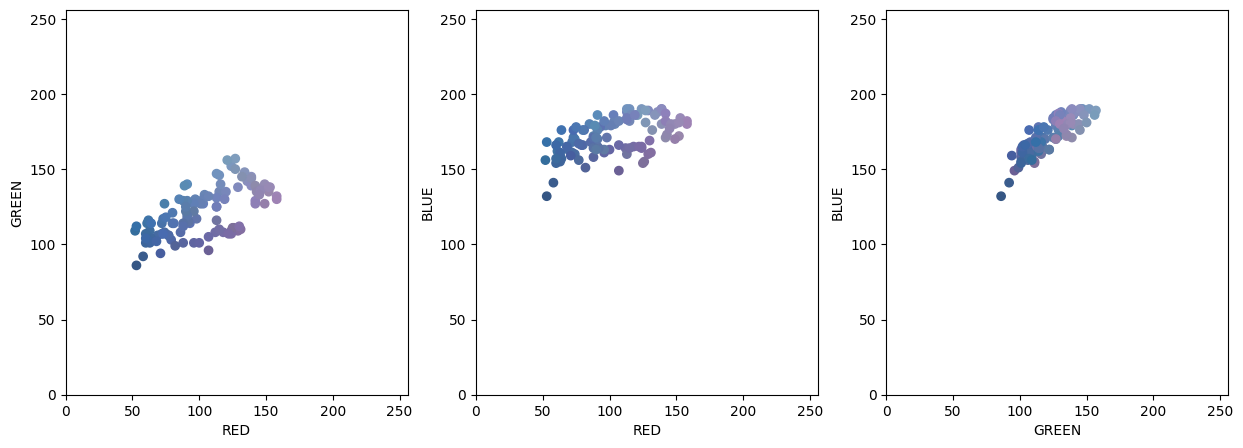

In [43]:
## Visualize distribution of training points

fig, axs = plt.subplots(1,3,figsize=(15,5))
axs[0].scatter(yes_points[:,0],yes_points[:,1], c = yes_points/255)
axs[0].set_xlim((0,256))
axs[0].set_xlabel("RED")
axs[0].set_ylim((0,256))
axs[0].set_ylabel("GREEN")
axs[1].scatter(yes_points[:,0],yes_points[:,2], c = yes_points/255)
axs[1].set_xlim((0,256))
axs[1].set_xlabel("RED")
axs[1].set_ylim((0,256))
axs[1].set_ylabel("BLUE")
axs[2].scatter(yes_points[:,1],yes_points[:,2], c = yes_points/255)
axs[2].set_xlim((0,256))
axs[2].set_xlabel("GREEN")
axs[2].set_ylim((0,256))
axs[2].set_ylabel("BLUE")

After you run the next section, a new Napari window will appear with highlighted in green all the nuclei in the ROI.

In [44]:
settings.application.ipy_interactive = True

imarray0=ROI_image.copy()

imR=imarray0[:,:,0]
imG=imarray0[:,:,1]
imB=imarray0[:,:,2]

yes_points_hsv=rgb_to_hsv(yes_points)

scaler = StandardScaler()
yes_points_scaled = scaler.fit_transform(yes_points_hsv)

sensitivity = 0.1  # Choose sensitivity level (e.g., 10% of points allowed as outliers)
clf = OneClassSVM(kernel='rbf', nu=sensitivity, gamma='scale')
clf.fit(yes_points_scaled)

imV=np.zeros(np.shape(imR))
for i in range(step,np.shape(imV)[0]):
    for j in range(step,np.shape(imV)[1]):
        #print(pR)
        if (mask_filled[i,j]>0):
            pR=imR[i,j]
            pG=imG[i,j]
            pB=imB[i,j]
            X = np.array([
                [pR, pG, pB]
            ])
            #print(X)
            X_hsv = rgb_to_hsv(X)
            X_scaled = scaler.transform(X_hsv)
            #print(X_scaled)
            predictions = clf.predict(X_scaled)
            #print(predictions)
            if predictions>0:
                imV[i,j]=1
                #yes_points=np.append(yes_points,X,axis=0)
            else:
                imV[i,j]=0
                #no_points=np.append(no_points,X,axis=0)
        else:
            j+=step

viewer_0 = napari.Viewer()

viewer_0.add_image(imarray0, name='Original', 
                colormap='grey', blending='additive')
viewer_0.add_image(imV, name='Violet', 
                colormap='green', blending='additive')

<Image layer 'Violet' at 0x79ed8c8b6950>

### Output
Creates a .tiff file with multiple pages. P1 is the original image, P2 is the ROI chosen as the tissue, P3 is the detected nuclei.

In [45]:
viewer_0 = napari.Viewer()

viewer_0.add_image(imarray, name='Original', 
                colormap='grey', blending='additive')
viewer_0.add_image(imarray0, name='ROI', 
                colormap='grey', blending='additive')
viewer_0.add_image(imV, name='Violet', 
                colormap='green', blending='additive')

rgb_im=Image.fromarray(imarray,mode="RGB")
rgb0_im=Image.fromarray(imarray0,mode="RGB")
b_im=Image.fromarray(imV)

# Save both images in a single TIFF file
output_path = tiff_stem+"_output.tiff"
rgb_im.save(output_path, save_all=True, append_images=[rgb0_im,b_im])

print(f"TIFF file saved at: {output_path}")

TIFF file saved at: cow1_d0_1_1_output.tiff
